In [8]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

Z_tab = Table.read("gal_fiboh_dr7_v5_2.fits")
M_tab = Table.read("totlgm_dr7_v5_2.fit")
S_tab = Table.read("gal_totsfr_dr7_v5_2.fits")

idx = np.where((M_tab['MEDIAN']>5) & (Z_tab['MEDIAN']>0) & (S_tab['MEDIAN']>-50))
M = list(M_tab['MEDIAN'][idx])
Z = list(Z_tab['MEDIAN'][idx])
S = list(S_tab['MEDIAN'][idx])
M, Z, S = (np.array(t) for t in zip(*sorted(zip(M, Z, S))))

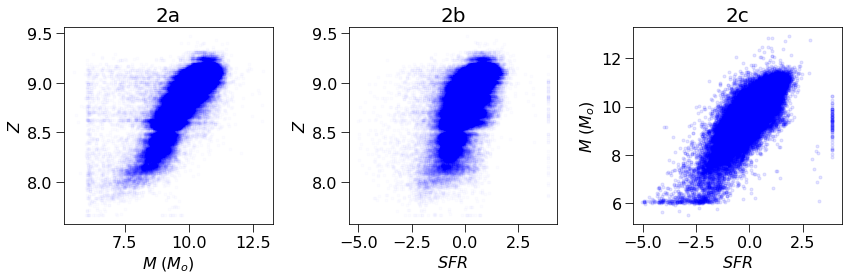

In [94]:
plt.figure(1, figsize=(12,4))
plt.subplot(131); plt.title('2a');
plt.plot(M, Z, 'b.', alpha=0.01)
plt.xlabel('$M\;(M_{o})$', fontsize=16); plt.ylabel('$Z$', fontsize=16)
plt.subplot(132); plt.title('2b')
plt.plot(S, Z, 'b.', alpha=0.01)
plt.xlabel('$SFR$', fontsize=16); plt.ylabel('$Z$', fontsize=16);
plt.subplot(133); plt.title('2c')
plt.plot(S, M, 'b.', alpha=0.1)
plt.xlabel('$SFR$', fontsize=16); plt.ylabel('$M\;(M_{o})$', fontsize=16)
plt.tight_layout()

### WRITTEN ANSWERS

2a) The dependence of metallicity on solar mass may be in part explained by outflows.  Galaxies of smaller mass have lower metal abundances because their lower escape velocities (Yates et al, 2011)

2c) At given stellar mass, the strength of the correlation between gas-phase metallicity and star formation rate varies, as shown in the figure below.  Correlation coefficient between Z and SFR is plotted as a function of stellar mass, with red regions showing weak correlation and yellow showing moderate correlation (assuming a linear relationship).  The correlation is strongest (and positive) at the lowest and highest ends of the mass range.

### 2d) WHY ARE Z AND S CORRELATED???

Text(0,0.5,'$Correlation \\: Coefficient$')

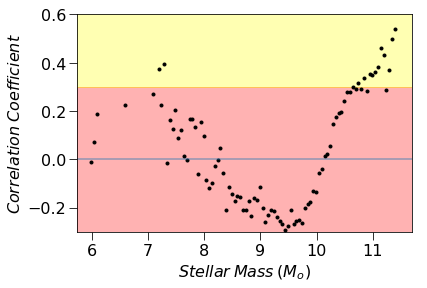

In [95]:
M_bins = np.arange(M[12], M[-1], .05)
corrs = np.zeros(len(M_bins))
for i in range(len(M_bins)-1):
    idx = np.where((M > M_bins[i]) & (M < M_bins[i+1]))
    if len(M[idx]) > 50:
        corrs[i] = np.corrcoef(Z[idx], S[idx])[0,1]
good = np.where(corrs != 0)    
plt.plot(M_bins[good], corrs[good], 'k.')
plt.axhspan(-0.3, 0.3, color='red', alpha=0.3)
plt.axhspan(0.3, 0.7, color='yellow', alpha=0.3)
plt.axhline(0, alpha=0.5)
plt.axis([5.75, 11.7, -.3, 0.6])
plt.xlabel('$Stellar \: Mass \:(M_o)$', fontsize=16)
plt.ylabel('$Correlation \: Coefficient$', fontsize=16)

Text(0,0.5,'$Correlation \\: Coefficient$')

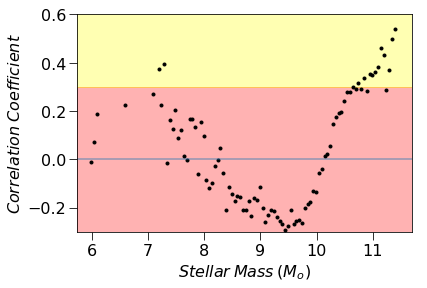

In [350]:
M_bins = np.arange(M[12], M[-1], .05)
corrs = np.zeros(len(M_bins))
for i in range(len(M_bins)-1):
    idx = np.where((M > M_bins[i]) & (M < M_bins[i+1]))
    if len(M[idx]) > 50:
        corrs[i] = np.corrcoef(Z[idx], S[idx])[0,1]
good = np.where(corrs != 0)    
plt.plot(M_bins[good], corrs[good], 'k.')
plt.axhspan(-0.3, 0.3, color='red', alpha=0.3)
plt.axhspan(0.3, 0.7, color='yellow', alpha=0.3)
plt.axhline(0, alpha=0.5)
plt.axis([5.75, 11.7, -.3, 0.6])
plt.xlabel('$Stellar \: Mass \:(M_o)$', fontsize=16)
plt.ylabel('$Correlation \: Coefficient$', fontsize=16)

# 3a

In [349]:
m_g = 16.86
z = 0.1
c = 3e5 # km/s
H = 70.4  #km /s /Mpc
v =  c * z #km /s 
d = (v / H) * 1e6 #pc
M_g = m_g - 5 * np.log10(d/10)
M_g

-21.287742977887753

# 3b-c

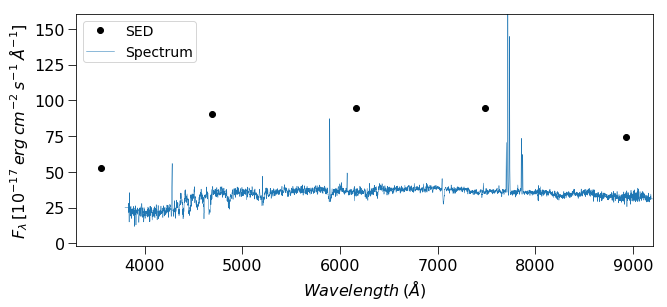

In [348]:
# organize photometry data
filters = ['u', 'g', 'r', 'i', 'z']
mags = np.array([18.06, 16.88, 16.23, 15.81, 15.69])
mag_errs = np.array([0.02, 0, 0, 0, 0.01])
cents = np.array([3551, 4686, 6165, 7481, 8931])

# calculate flux magnitudes
ν = 3e18 / cents
f_ν = 10**((mags+48.57)/(-2.5))
f_λ = f_ν * ν**2 / (3e8 * 1e10)
f_ν_err = 10**((mag_errs+48.57)/(-2.5))
f_λ_err = f_ν_err * ν**2 / (3e8 * 1e10)

#Read in spec file
spec_file = "spSpec-51788-0401-161.fit"
hdul = fits.open(spec_file)
data = hdul[0].data
spec = np.array(data[0])
spec_err = np.array(data[2])
x = np.linspace(3800, 9200, len(spec))  ###CHEATED ON WV RANGE

#Plot stuff
plt.figure(1, figsize=(9, 4))
plt.plot(cents, f_λ*1e17, 'ko', label='SED')
plt.plot(x, spec, '-', linewidth=0.5, label='Spectrum')
plt.axis([np.min(x)-500, np.max(x), -2, 160])

plt.xlabel('$Wavelength \: (\AA)$', fontsize=16)
plt.ylabel('$F_\lambda \: [10^{-17} \: erg \: cm^{-2} \: s^{-1} \: \AA^{-1}]$', fontsize=16)
plt.legend(loc=2, fontsize=14)
plt.tight_layout()